# Time Series Forecasting - A Showcase Example

The objective of this project is to make time series forecasting on weather data. The [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by [the Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/). The section of the dataset used for this homework was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

The dataset consists of 19 features measured every hour for 8 years (from 2009 to 2016 included). We will try to predict the temperature `T (degC)` for the next 48 hours using previous data (including the temperature). We choose a window input of one week.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import torch

## I ☁️ Load the weather dataset

The dataset is a csv filed called `weather_dataset.csv` and the index column correspond to the `"Date Time"`.

In [2]:
# load weather dataset with the date as index
weather_dataset = pd.read_csv('data/weather_dataset.csv', index_col="Date Time")

# format date index
weather_dataset.index = pd.to_datetime(weather_dataset.index, format="%d.%m.%Y %H:%M:%S")

# show the first 5 time steps
weather_dataset.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


## II 🔎 Explore the dataset

In [3]:
print(f"The dataset has {weather_dataset.shape[0]} samples and {weather_dataset.shape[1]} features")

The dataset has 70091 samples and 19 features


### II.1 ↔️ Correlations

Let's explore the correlation between features. We might be able to reduce the number of features and ease data exploration and model training.

All features with a correlation strictly above 0.95 will be remove.

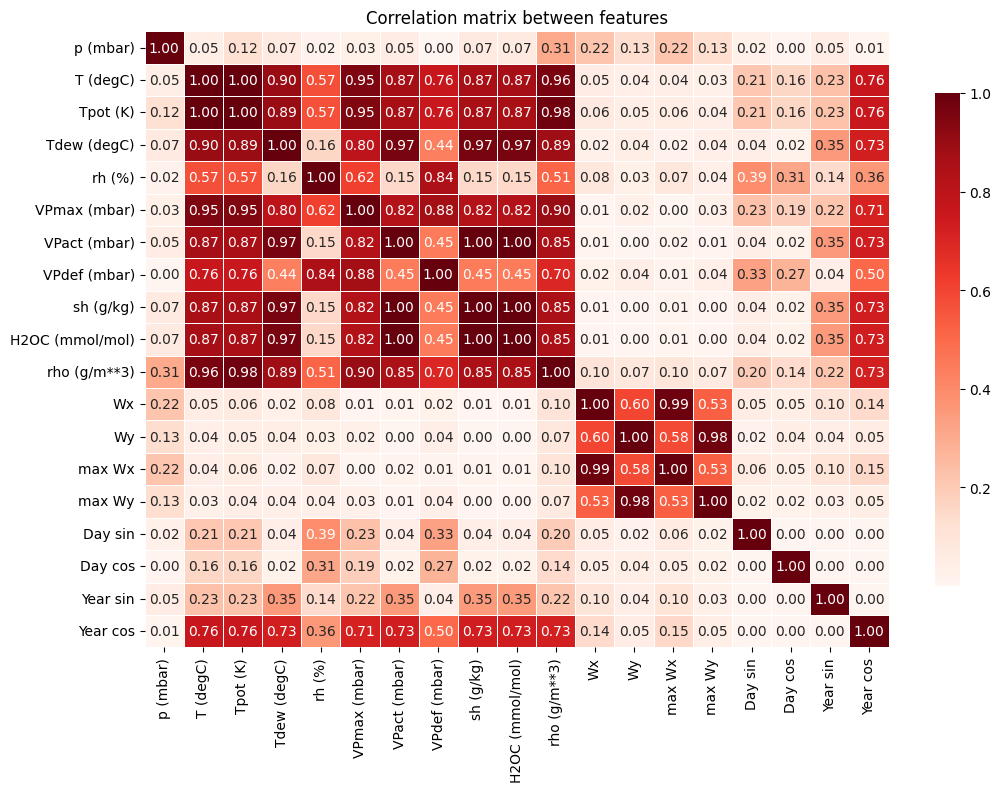

The removed features are: ['Tpot (K)', 'VPmax (mbar)', 'VPact (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'max Wx', 'max Wy']
The remaining features are: Index(['p (mbar)', 'T (degC)', 'Tdew (degC)', 'rh (%)', 'VPdef (mbar)', 'Wx',
       'Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')
Hence the shape of the reduced dataset is: (70091, 11)


In [4]:
# compute correlations
features_correlation_matrix = weather_dataset.corr().abs()

# visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(features_correlation_matrix, cmap='Reds', annot=True, fmt=".2f", cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.title('Correlation matrix between features')
plt.show()

# set the diagonal and lower triangle to zero (we only want to remove one element of pairs)
upper = features_correlation_matrix.where(~np.tril(np.ones(features_correlation_matrix.shape)).astype(bool))

# find index/column names of pairs with correlation greater than 0.95
features_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# drop highly correlated columns
reduced_weather_dataset = weather_dataset.drop(columns=features_to_drop)

print(f"The removed features are: {features_to_drop}")
print(f"The remaining features are: {reduced_weather_dataset.columns}")
print(f"Hence the shape of the reduced dataset is: {reduced_weather_dataset.shape}")

<div class="alert alert-info">

We can see an interesting correlation between `Year cos` and the temperature `T (degC)` which suggest an important yearly seasonality.

### II.2 ❓ Data types and missing values

In [5]:
reduced_weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70091 entries, 2009-01-01 01:00:00 to 2016-12-31 23:10:00
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p (mbar)      70091 non-null  float64
 1   T (degC)      70091 non-null  float64
 2   Tdew (degC)   70091 non-null  float64
 3   rh (%)        70091 non-null  float64
 4   VPdef (mbar)  70091 non-null  float64
 5   Wx            70091 non-null  float64
 6   Wy            70091 non-null  float64
 7   Day sin       70091 non-null  float64
 8   Day cos       70091 non-null  float64
 9   Year sin      70091 non-null  float64
 10  Year cos      70091 non-null  float64
dtypes: float64(11)
memory usage: 6.4 MB


<div class="alert alert-info">

The dataset do not have missing values and values are all in `float64`.

### II.3 ⏲️ Time steps study

With time series, several things are important to test as they have a huge impact on how we sould treat the dataset.

Here, we will check if time steps are:
- correctly ordered
- spaced equally
- not duplicated

In [6]:
# compute the length of the time steps
indexes = pd.Series(reduced_weather_dataset.index)
all_time_steps_lengths = indexes - indexes.shift()
time_steps_lengths_count = all_time_steps_lengths.value_counts()

print(time_steps_lengths_count)

Date Time
0 days 01:00:00      70083
0 days 01:10:00          2
0 days 01:20:00          1
-1 days +01:00:00        1
-2 days +18:30:00        1
0 days 16:50:00          1
3 days 03:10:00          1
Name: count, dtype: int64


<div class="alert alert-info">

We can see here that there are negative time steps duration. Therefore, the dataset is not sorted by date. Let's sort it and compute this time step length again.

In [7]:
# sort dataset
sorted_dataset = reduced_weather_dataset.sort_index()

# compute the length of the time steps
indexes = pd.Series(sorted_dataset.index)
all_time_steps_lengths = indexes - indexes.shift()
time_steps_lengths_count = all_time_steps_lengths.value_counts()

print(time_steps_lengths_count)

Date Time
0 days 01:00:00    70000
0 days 00:30:00       61
0 days 00:00:00       24
0 days 01:10:00        2
0 days 01:20:00        1
0 days 16:50:00        1
3 days 03:10:00        1
Name: count, dtype: int64


<div class="alert alert-info">

Now we have only positive time steps, but three problems appear:
- There are 24 duplicates that we will drop in the following cell.
- There are time steps close to one hour or smaller than one hour. We will take the mean for each hour and hope to reduce this problems.
- There are gaps that cannot be filled. We will leave them and remove windows that possess such gaps after windowing. To do so, we will define a function here.

In [8]:
# drop duplicates
clean_dataset = sorted_dataset.drop_duplicates()

# resample to one hour by taking the mean for each hour
clean_dataset = clean_dataset.resample('h').mean()

# remove time steps that were filled with NaN values
clean_dataset = clean_dataset.dropna()

# confirm we solved part of the problems
indexes = pd.Series(clean_dataset.index)
all_time_steps_lengths = indexes - indexes.shift()
time_steps_lengths_count = all_time_steps_lengths.value_counts()

print(time_steps_lengths_count)

Date Time
0 days 01:00:00    70034
0 days 17:00:00        1
3 days 03:00:00        1
Name: count, dtype: int64


In [9]:
# define function to ensure a time series have regular time steps
def have_regular_time_steps(time_series):
    indexes = pd.Series(time_series.index)
    all_time_steps_lengths = indexes - indexes.shift()
    time_steps_lengths_count = all_time_steps_lengths.value_counts()
    return len(time_steps_lengths_count) == 1

# quickly test the function
assert not have_regular_time_steps(clean_dataset)  # the whole dataset have gaps
assert have_regular_time_steps(clean_dataset.iloc[:(31 * 24)])  # the first month do not have gaps

### II.4 📶 Dataset distribution

We will:
- Show dataset statistics.
- Visualize features distribution.

In [10]:
# compute dataset statistics
clean_dataset.describe()

,p (mbar),T (degC),Tdew (degC),rh (%),VPdef (mbar),Wx,Wy,Day sin,Day cos,Year sin,Year cos
count,70037.000000,70037.000000,70037.000000,70037.000000,70037.000000,70037.000000,70037.000000,7.003700e+04,7.003700e+04,70037.000000,70037.000000
mean,989.214128,9.442833,4.954083,76.029967,4.036448,-0.626668,-0.406815,-2.674072e-05,-7.375082e-05,0.001191,-0.000417
std,8.361298,8.421184,6.730542,16.459548,4.893142,1.985749,1.552214,7.071103e-01,7.071121e-01,0.706796,0.707427
min,913.600000,-22.760000,-24.800000,13.880000,0.000000,-11.305514,-8.274385,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000
25%,984.200000,3.340000,0.240000,65.240000,0.870000,-1.469633,-1.364738,-7.071068e-01,-7.071068e-01,-0.704896,-0.707815
50%,989.570000,9.400000,5.210000,79.300000,2.180000,-0.633055,-0.293467,2.697701e-14,1.072788e-14,0.002071,-0.001184
75%,994.730000,15.470000,10.070000,89.500000,5.290000,0.299841,0.450039,7.071068e-01,7.071068e-01,0.707789,0.707837
max,1015.290000,37.280000,23.060000,100.000000,46.010000,8.244699,7.733831,1.000000e+00,1.000000e+00,1.000000,1.000000


<div class="alert alert-info">

The dataset have a large diversity of values, normalization will be required to obtain better results.

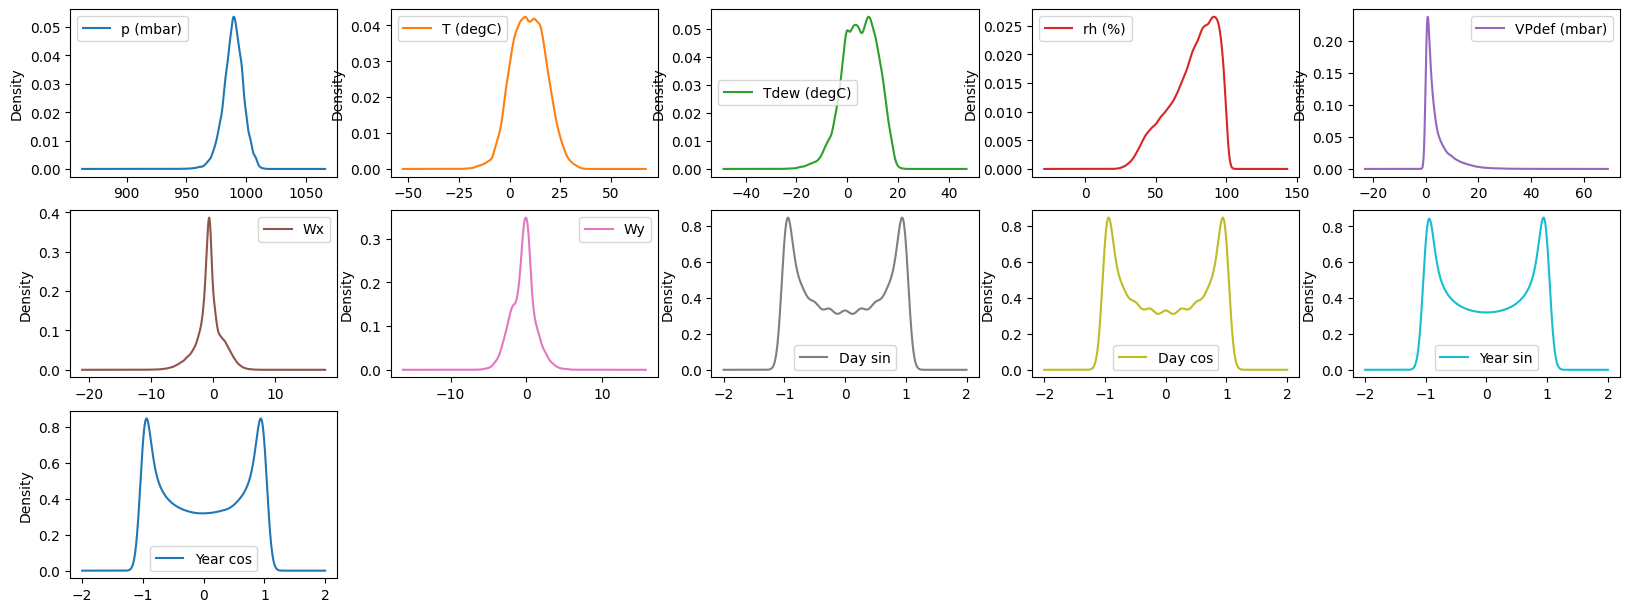

In [11]:
# show features distributions
clean_dataset.plot(kind="density", subplots=True, layout=(4, 5), sharex=False, figsize=(20,10))
plt.show()

<div class="alert alert-info">

We can see that:
- The temperature (T (degC)) is close to a normal distribution centered on 5 or 10 celsius degrees.
- rh% have a high density close to 100 but is limited to 100.
- Wind related features (Wx, Wy) are centered on zero.
- Time related features (Day sin, Day cos, Year sin, Year cos) are between -1 and 1 with spikes on -1 and 1. This is coherent with a cosinus or sinus function.

### II.5 📈 Features evolution along time.

Let's see how our features evolve and if we can detect seasonality. We begin by showing the whole dataset (*i.e.* the 8 years).

/var/folders/qw/hl3htbzn48d63s9v3rgj11v00000gn/T/ipykernel_7376/1758000556.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([str(year) for year in range(2009, 2017)])


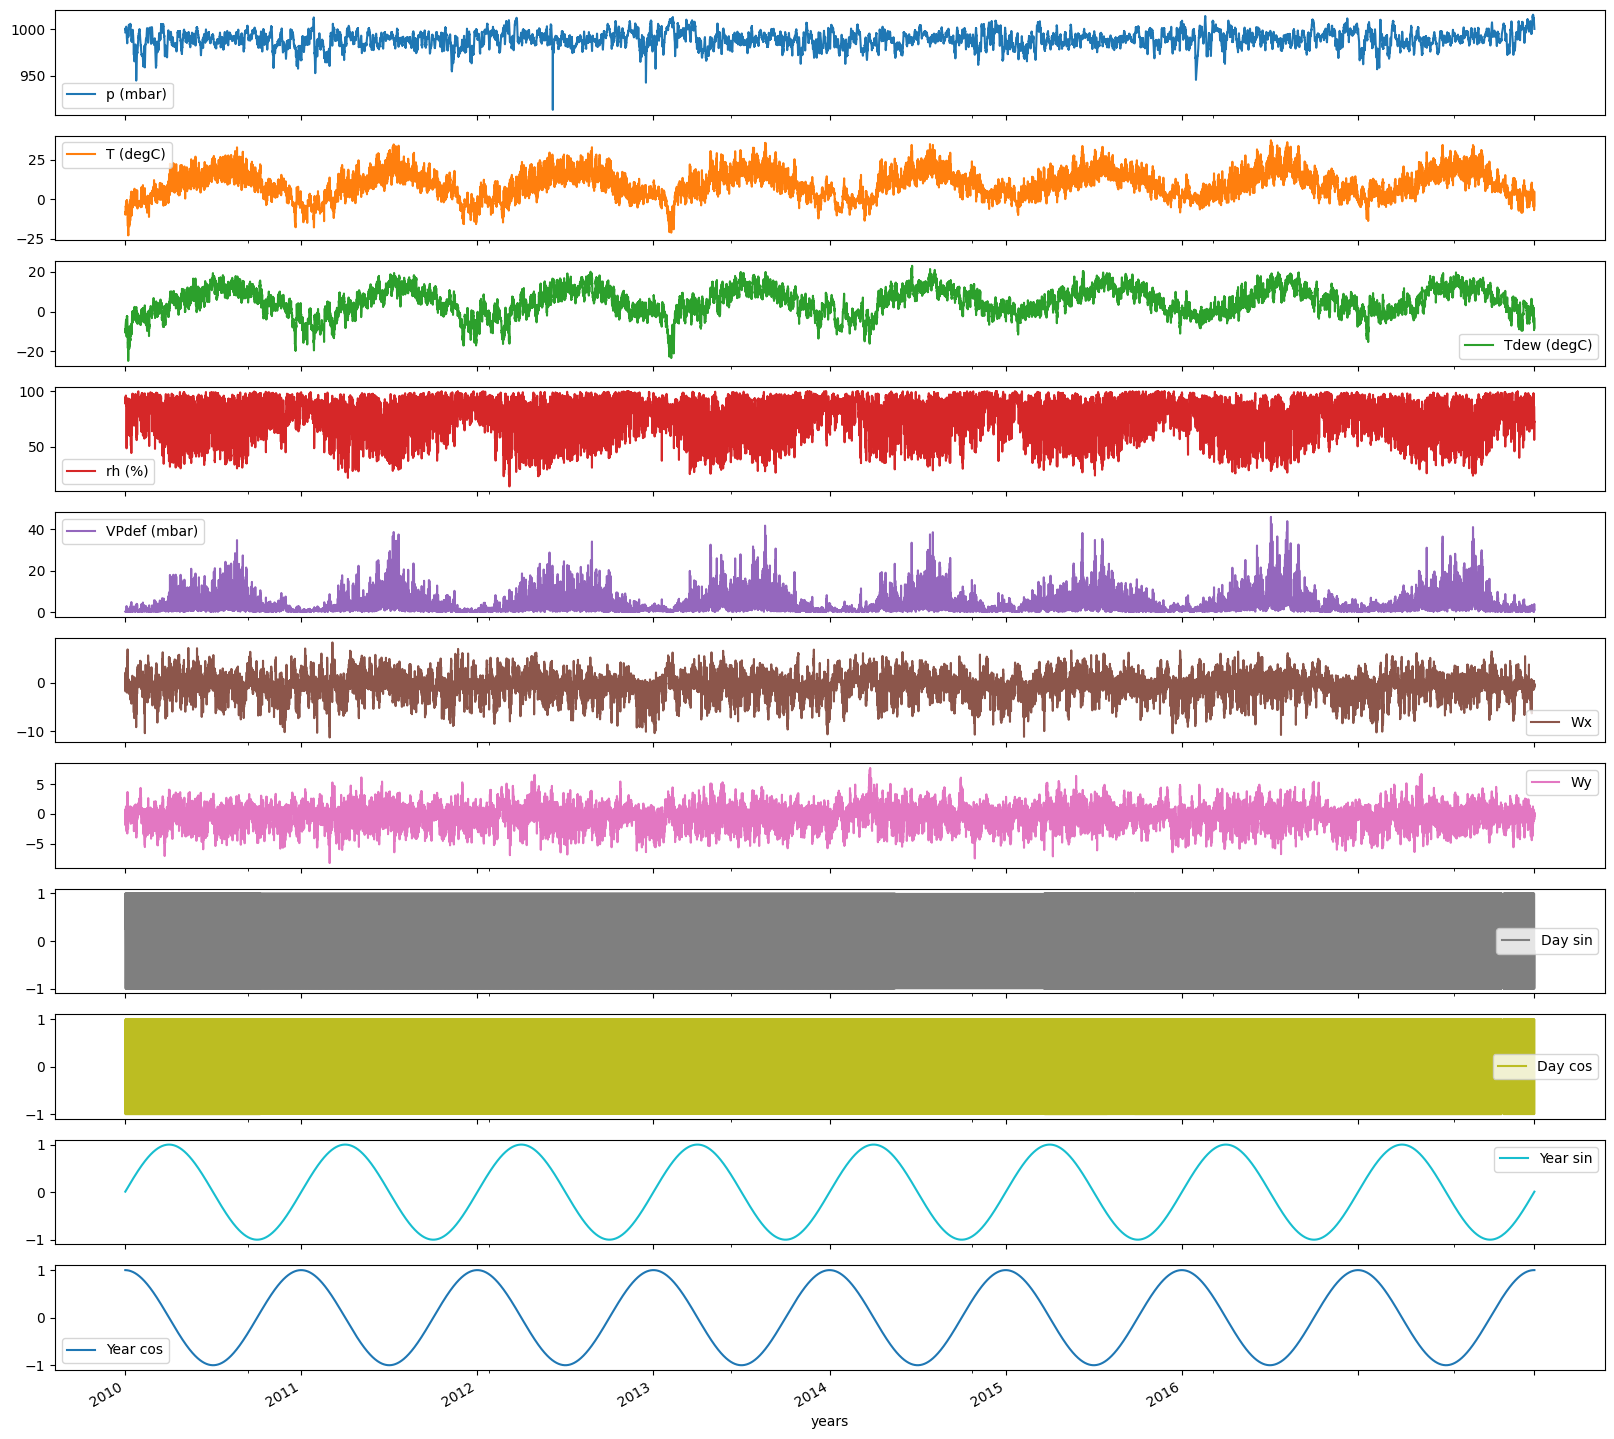

In [12]:
# show features evolution over time
axes = clean_dataset.plot(subplots=True, figsize=(20,20), layout=(11, 1),
                          sharex=True, sharey=False, xlabel="years")

# set xticks labels
for ax in axes:
    ax[0].set_xticklabels([str(year) for year in range(2009, 2017)])
plt.show()

<div class="alert alert-info">

As we could expect from weather data, there seem to be a yearly seasonality. We will verify it through an FFT afterward, but for now let's zoom on a one month period. We expect a daily seasonality.

/var/folders/qw/hl3htbzn48d63s9v3rgj11v00000gn/T/ipykernel_7376/2144189016.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([str(year) for year in range(1, 32)])
/var/folders/qw/hl3htbzn48d63s9v3rgj11v00000gn/T/ipykernel_7376/2144189016.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([str(year) for year in range(1, 32)])
/var/folders/qw/hl3htbzn48d63s9v3rgj11v00000gn/T/ipykernel_7376/2144189016.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([str(year) for year in range(1, 32)])
/var/folders/qw/hl3htbzn48d63s9v3rgj11v00000gn/T/ipykernel_7376/2144189016.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([str(year) for year in range(1, 32)])
/var/folders/qw/hl3htbzn48d63s9v3rgj11v00000gn/T/ipykernel_7376/2144189016.py:8: UserWarning: FixedFormatter should only be used

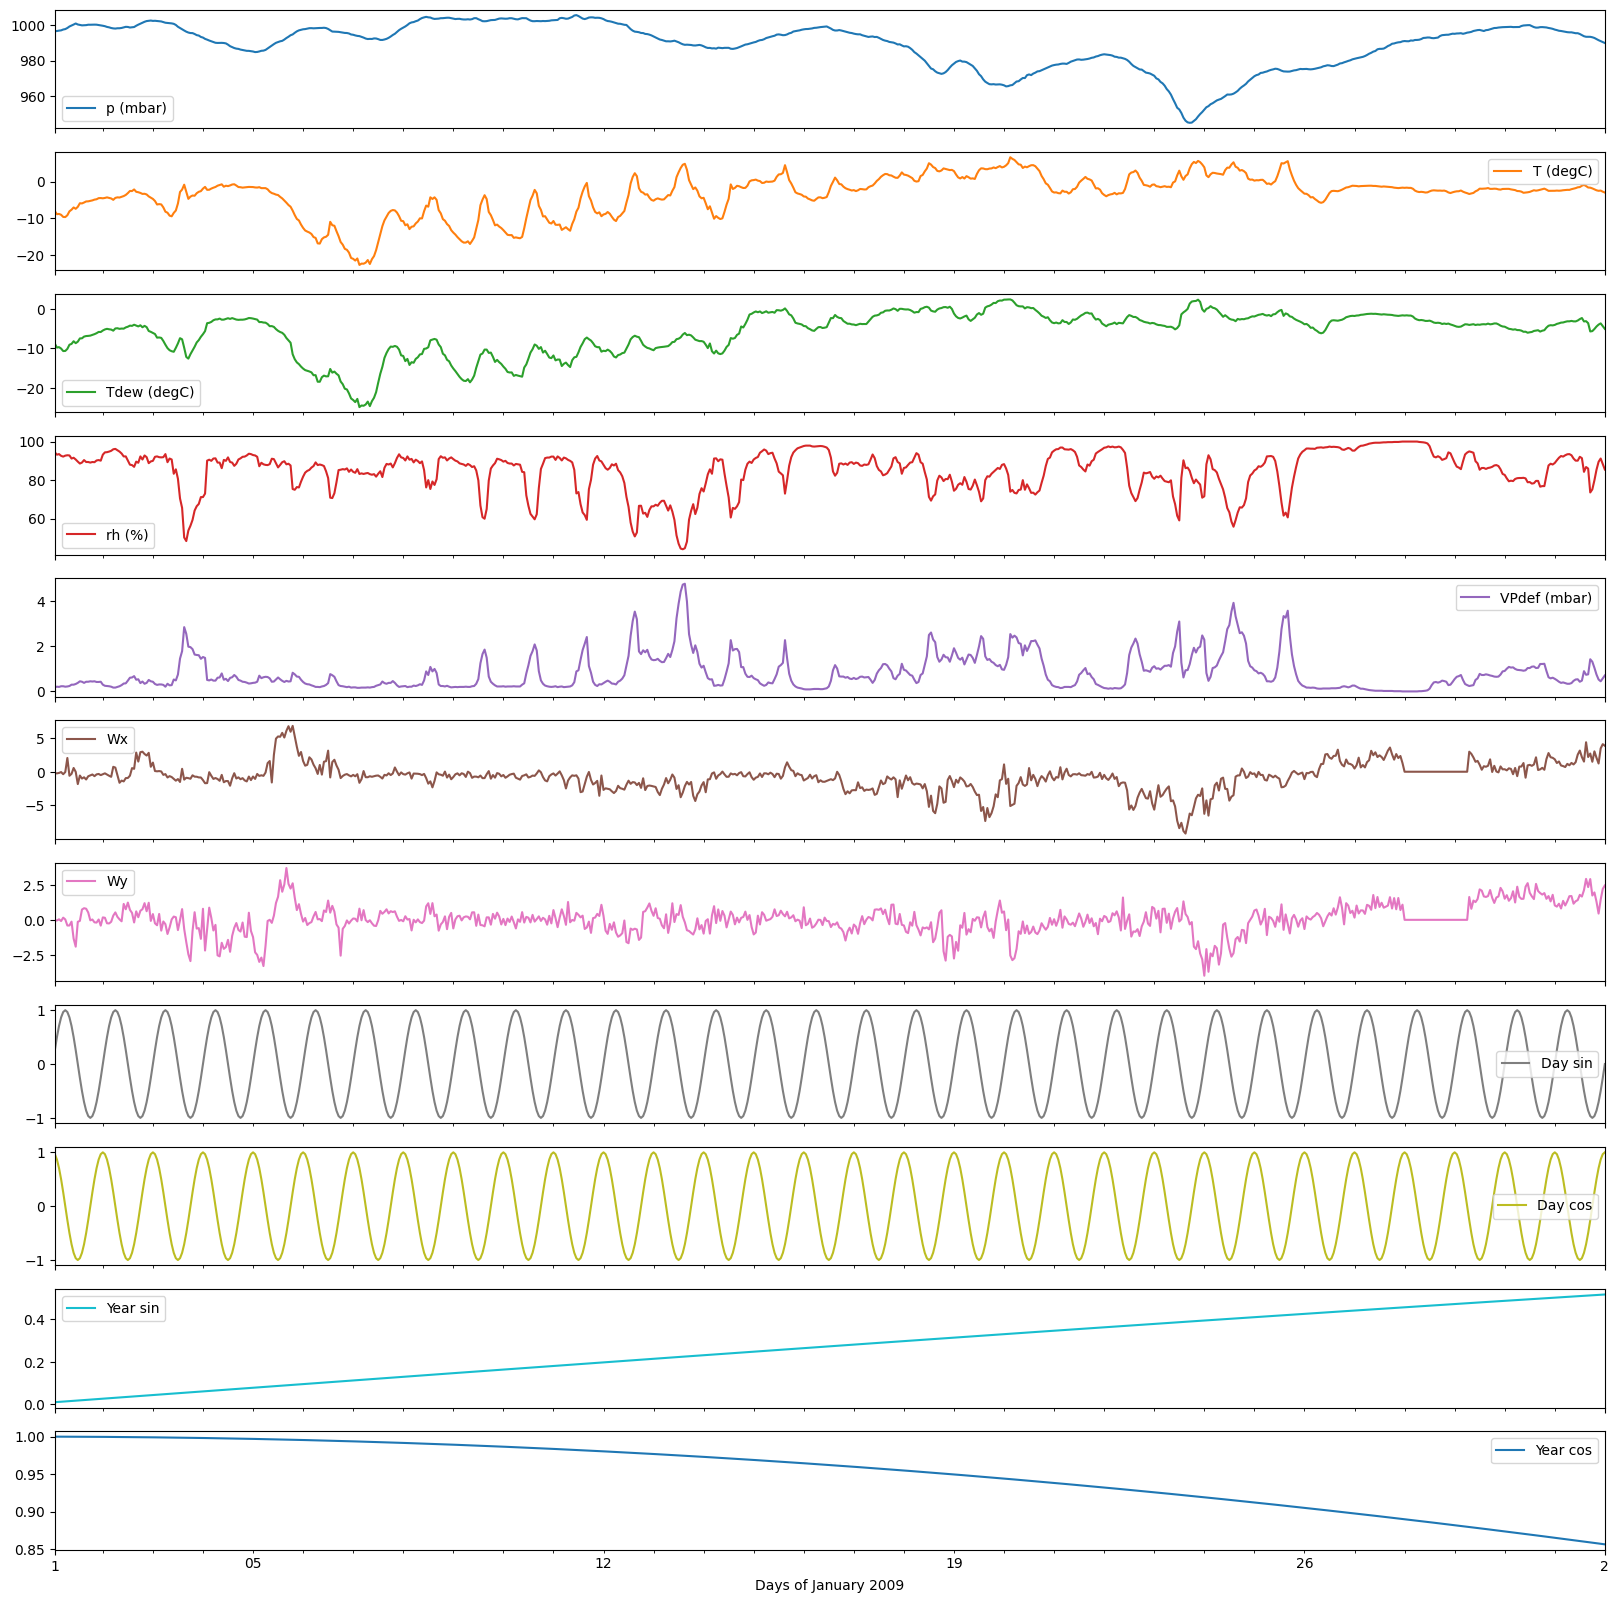

In [13]:
# show features evolution over time
axes = clean_dataset.iloc[:(31 * 24)].plot(subplots=True, figsize=(20,20), layout=(11, 1),
                                           sharex=True, sharey=False,
                                           xlabel="Days of January 2009")

# set xticks labels
for ax in axes:
    ax[0].set_xticklabels([str(year) for year in range(1, 32)])
plt.show()

<div class="alert alert-info">

The daily seasonality also appears, but not on all features, futhermore, it is less clear. However, we only looked at one month, let's study the dataset in the frequency domain.

### II.6 📊 Frequency analysis

To analyze the dataset in the frequency domain, we use the Fourier transformation in its optimized version fft.

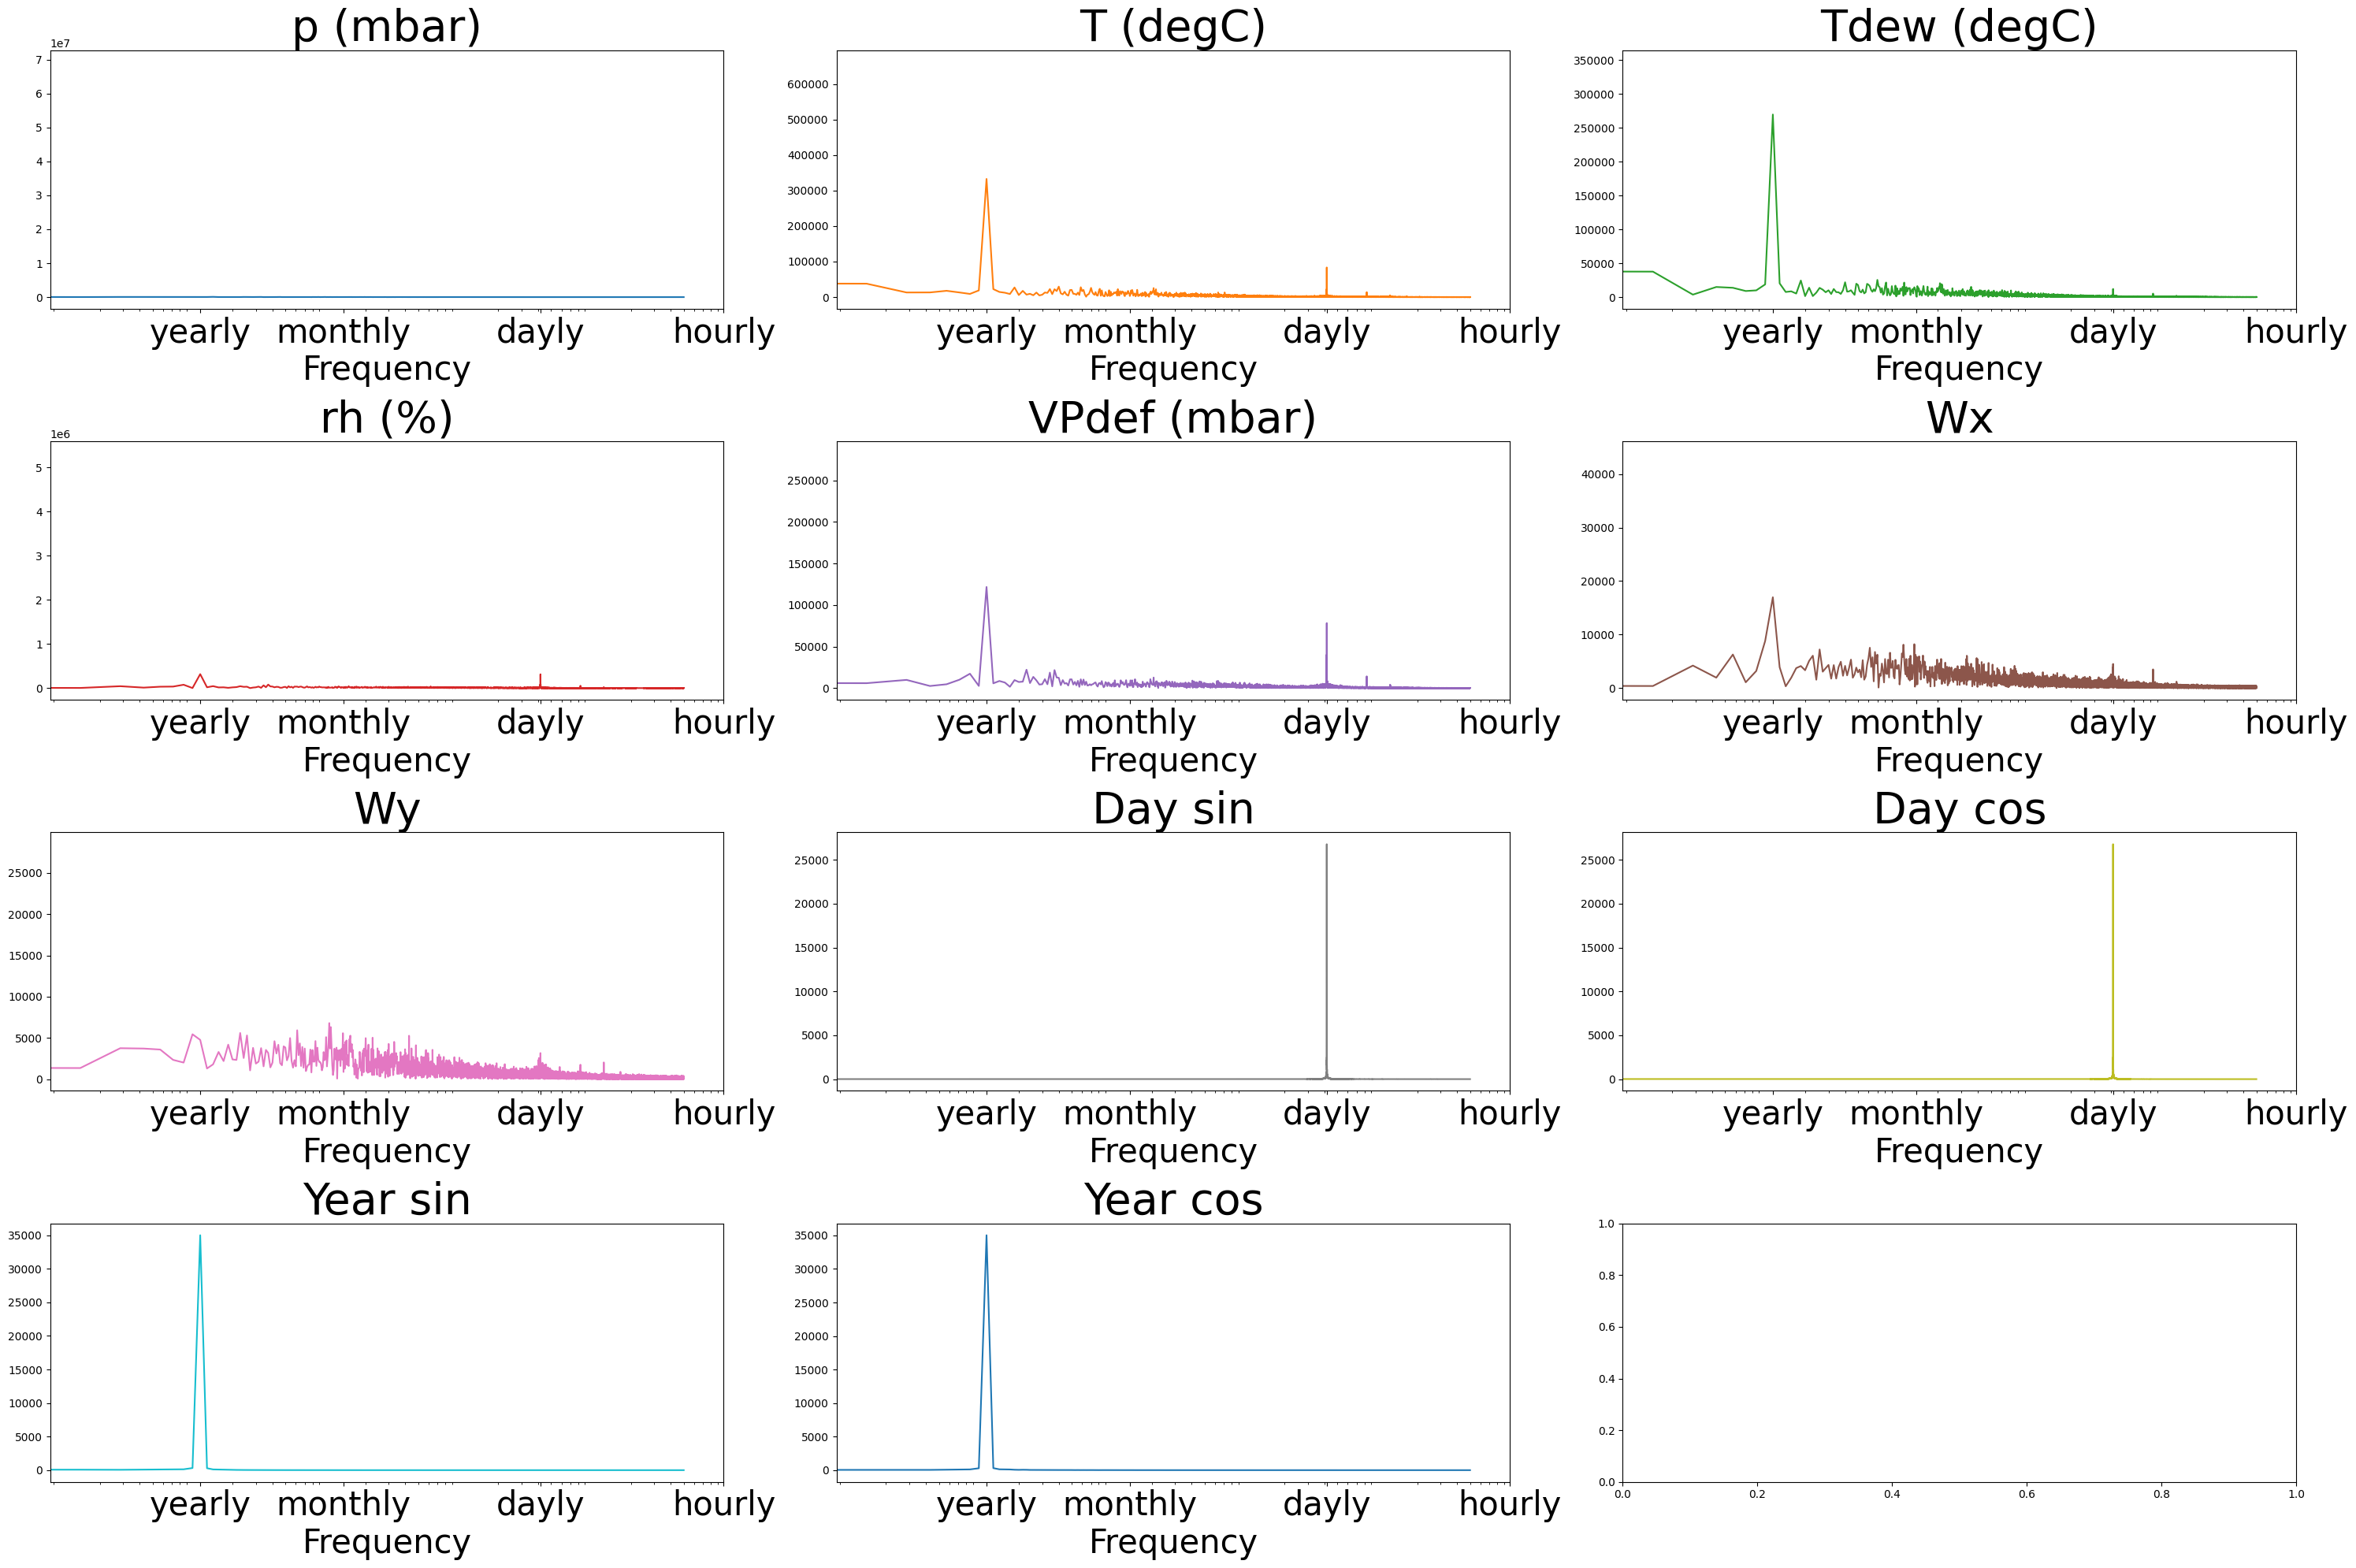

In [14]:
from math import ceil
nb_cols = 3
cmap = plt.get_cmap('tab10')
fig, axes = plt.subplots(nrows=ceil(clean_dataset.shape[1] / nb_cols),
                         ncols=nb_cols,
                         figsize=(30,20))

# compute the frequencies (x axis of the plot)
sampling_rate = 1  # 1 sample per hour
nb_timesteps = clean_dataset.shape[0]
freq = np.fft.fftfreq(nb_timesteps, d=1/sampling_rate)
freq = freq[:nb_timesteps//2]

# iterate on each feature
for i, feature in enumerate(clean_dataset.columns):
    ax = axes[i//nb_cols, i%nb_cols]

    # fft for the given feature
    fft_values = np.fft.fft(clean_dataset[feature])

    # keep only positive frequencies
    fft_values = np.abs(fft_values)[:nb_timesteps//2]

    # plot fft
    ax.plot(freq, fft_values, label=feature, color=cmap(i % 10))

    ax.set_title(feature, fontsize=40)

    # set x-axis to log scale and set x-axis label for interpretable frequency
    ax.set_xscale("log")
    ax.set_xlabel("Frequency", fontsize=30)
    ax.set_xticks([1 / (24 * 365.2425), 1 / (24 * (365.2425 / 12)), 1 / 24, 1])
    ax.set_xticklabels(["yearly", "monthly", "dayly", "hourly"], fontsize=30)
plt.tight_layout()
plt.show()

<div class="alert alert-info">

We have now proved our daily and yearly seasonality. At least for the temperature, for other features there might not be one of the two seasonality.

## III 🛠️ Dataset Processing

Set features id to easily manipulate them.

In [15]:
# set variables to easily go from id to feature names and vice-versa
features_id2names = weather_dataset.columns
features_names2id = {name: id for id, name in enumerate(features_id2names)}

# stock target feature name and id
target_feature = "T (degC)"
target_feature_id = features_names2id[target_feature]

### III.1 ✂️ Split dataset between train val test

In the case of time series forecasting, we often aim for our final model to work for future data. In ou case, we expect the model to work well on weather forecast on years from 2017 and onward. To evaluate such capacity, the test set will consist of the three last years of the dataset (2015 and 2016). Therefore, the validation set will consist of the years 2013 and 2014.

The dataset consist of 8 years, 4 for training, 2 for validation, and 2 for testing.

In [16]:
# split between train, validation and test set (4/8 train, 2/8 validation, 2/8 test)
train_raw = clean_dataset[clean_dataset.index.year.isin([2009,2010,2011,2012])]
val_raw = clean_dataset[clean_dataset.index.year.isin([2013, 2014])]
test_raw = clean_dataset[clean_dataset.index.year.isin([2015, 2016])]

# show the resulting shapes
print(f"Train dataset shape: {train_raw.shape}")
print(f"Val dataset shape: {val_raw.shape}")
print(f"Test dataset shape: {test_raw.shape}")

Train dataset shape: (35063, 11)
Val dataset shape: (17504, 11)
Test dataset shape: (17470, 11)


### III.2 📶 Normalize dataset

We previously detected varying features order of magnitude, let's normalize the data.

In [17]:
# compute statistics over the train set
train_mean = train_raw.mean()
train_std = train_raw.std()
train_min = train_raw.min()
train_max = train_raw.max()

# apply normalization with the train set statistics
train_normalized = (train_raw - train_mean) / train_std
val_normalized = (val_raw - train_mean) / train_std
test_normalized = (test_raw - train_mean) / train_std

We define a function to rescale temperatures to an interpretable values to better understand error metrics.

In [18]:
def rescale_temperatures(temperature_vector):
    """
    Take normalized temperatures and find back the original values in degrees.
    """
    return temperature_vector * train_std[target_feature] + train_mean[target_feature]

### III.3 🗂️ Window dataset

In the current dataset, the samples correspond to time steps, however, we need samples and labels to correspond to windows of several hours/days. Labels do not need to have the same size as samples, they could be multivariate or single variate.

In our case we will make input windows of 4 days, output windows of 2 days, and a shift of 5 hours between each global window (input and output).

In [19]:
# set windows parameters
samples_window_size = 24 * 4  # four days
window_step = 5  # small shift that does not divide 24
labels_window_size = 24 * 2  # two days


# define a function to extract windows
def extract_windows(data,
                    samples_window_size=samples_window_size,
                    labels_window_size=labels_window_size,
                    window_step=window_step,
                    label_feature_id=target_feature_id):
    """
    Extract windows from the data with the given parameters.
    The windows are extracted with a sliding window approach.

    Then the windows are split into samples and labels.
    Finally labels are selected with the given feature.
    """
    window_size = samples_window_size + labels_window_size
    
    # extract windows with both samples and labels where there is no gaps
    windows = [data[time_step:time_step+window_size]
               for time_step in range(0, len(data) - window_size + 1, window_step)
               if have_regular_time_steps(data[time_step:time_step+window_size])]
    
    # convert the dataset to numpy as we now have 3 dimensions
    windows = np.array(windows)

    # split the windows into samples and labels
    samples = windows[:, :samples_window_size, :]
    labels = windows[:, samples_window_size:, label_feature_id]

    return samples, labels

# extract windows
train_sample_windows, train_label_windows = extract_windows(train_normalized)
val_sample_windows, val_label_windows = extract_windows(val_normalized)
test_sample_windows, test_label_windows = extract_windows(test_normalized)

# verification of the shape
print(f"train_sample_windows.shape: {train_sample_windows.shape}, train_label_windows.shape: {train_label_windows.shape}")
print(f"val_sample_windows.shape: {val_sample_windows.shape}, val_label_windows.shape: {val_label_windows.shape}")
print(f"test_sample_windows.shape: {test_sample_windows.shape}, test_label_windows.shape: {test_label_windows.shape}")

train_sample_windows.shape: (6984, 96, 11), train_label_windows.shape: (6984, 48)
val_sample_windows.shape: (3444, 96, 11), val_label_windows.shape: (3444, 48)
test_sample_windows.shape: (3437, 96, 11), test_label_windows.shape: (3437, 48)


We have extracted windows, the shapes seems coherent, but we should do some visualizations to be sure.

In [20]:
from visualization import plot_window

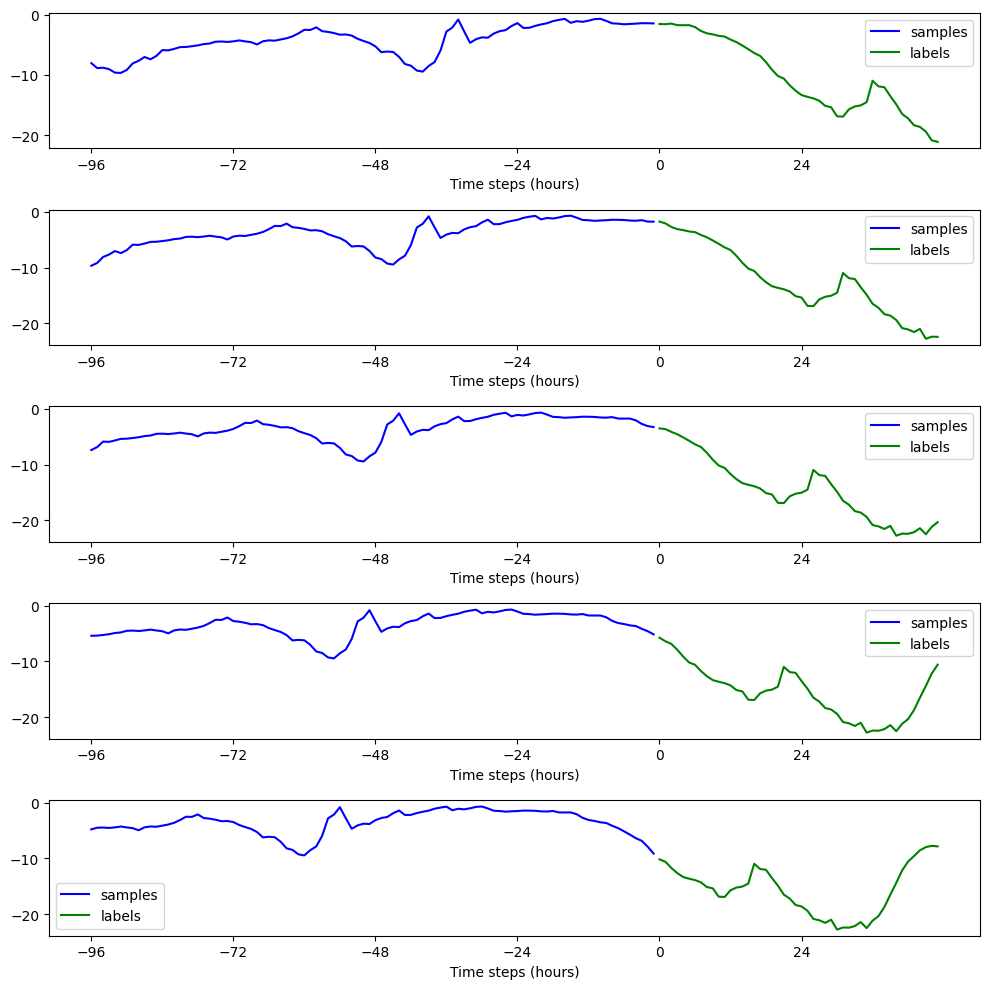

In [21]:
nb_samples_to_plot = 5

samples = rescale_temperatures(train_sample_windows[:, :, target_feature_id])
labels = rescale_temperatures(train_label_windows)

plot_window(samples, labels, nb_samples_to_plot=nb_samples_to_plot)

<div class="alert alert-info">

The curves correspond to what we expected, there is a 5 slide between each window, the input is a one week window while the target is a two days window.

## IV 🚀 Training models

We will now train our models. We start with baselines and then we try 2 types of models:
- Machine learning models
- Deep learning models

But before, let's define metrics and baselines.

### IV.1 🔬 Metric for model evaluation

We will use the mean absolute error (MAE) as our metric, it is easier to interpret than the mean square error (MSE), and we may have values around zero, thus the mean absolute percentage error (MAPE) is not adapted.

In [22]:
from sklearn.metrics import mean_absolute_error

def evaluate_model(model, samples, labels):
    """
    Evaluate the model on the given samples and labels.
    The samples and labels are scaled back to the original scale before the mean absolute error.
    """
    predictions = model(samples)
    predictions = rescale_temperatures(predictions)
    labels = rescale_temperatures(labels)

    mae = mean_absolute_error(labels, predictions)

    return mae

### IV.2 📏 Baselines

I have three baselines in mind:
- Predicting the t-1 value
- Predicting the mean of the input window
- Repeating the input window

#### a - Define baseline models

In [23]:
def last_step_baseline(inputs,
                       nb_steps_to_predict=labels_window_size,
                       label_feature_id=target_feature_id):
    """
    Predicts the last step of the input for all output time steps.
    """
    last_step_value = inputs[:, -1, label_feature_id]
    return np.tile(last_step_value[:, np.newaxis], (1, nb_steps_to_predict))

def mean_baseline(inputs,
                  nb_steps_to_predict=labels_window_size,
                  label_feature_id=target_feature_id):
    """
    Predicts the mean of the input for all output targets.
    """
    mean_value = np.mean(inputs[:, :, label_feature_id], axis=1)
    return np.tile(mean_value[:, np.newaxis], (1, nb_steps_to_predict))

def repeat_baseline(inputs,
                    nb_steps_to_predict=labels_window_size,
                    label_feature_id=target_feature_id):
    """
    Repeats the last part of the input, on a window of the same size as the output.
    """
    assert inputs.shape[1] >= nb_steps_to_predict, "Not enough steps in input to repeat"
    return inputs[:, -nb_steps_to_predict:, label_feature_id]

#### b - Quantitative evaluation

In [24]:
for baseline in [last_step_baseline, mean_baseline, repeat_baseline]:
    mae = evaluate_model(baseline, val_sample_windows, val_label_windows)
    print(f"Baseline {baseline.__name__} MAE: {mae:.3f}\n")

Baseline last_step_baseline MAE: 3.527

Baseline mean_baseline MAE: 3.520

Baseline repeat_baseline MAE: 3.195



#### c - Visualize predictions

Baseline last_step_baseline


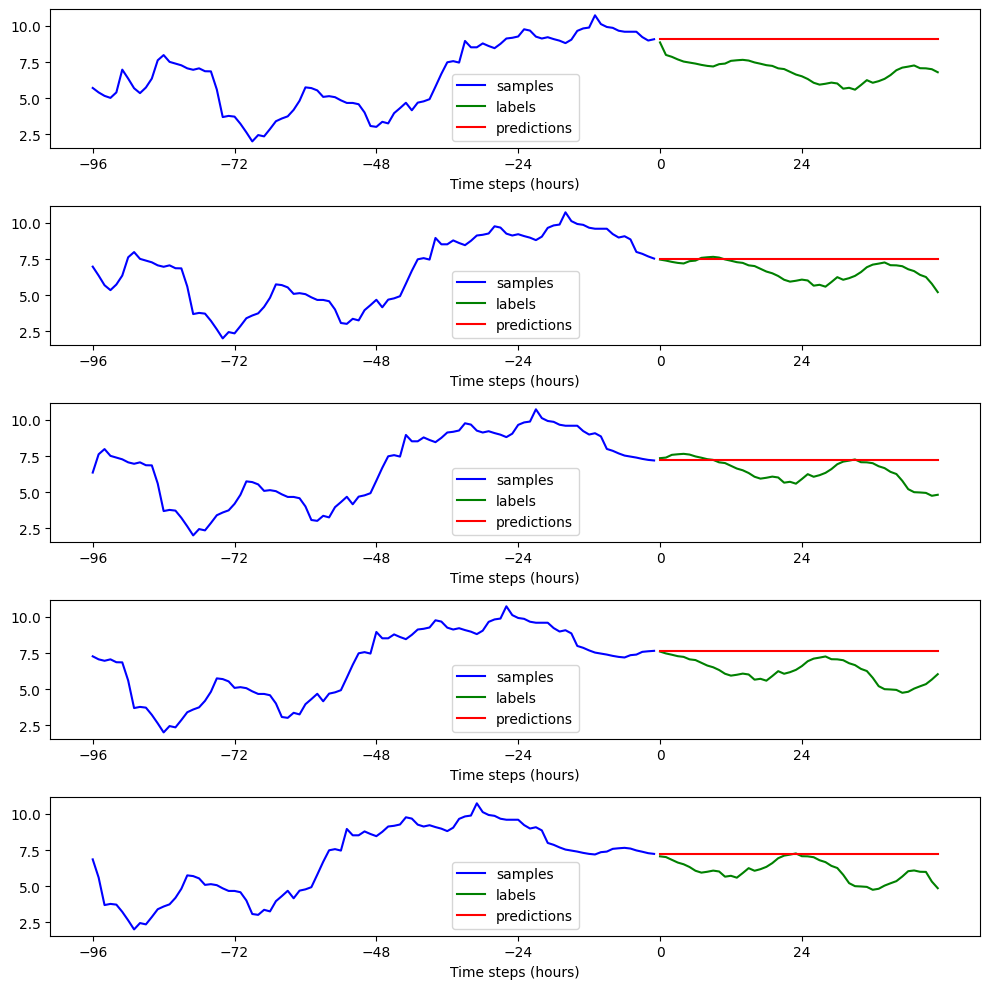

Baseline mean_baseline


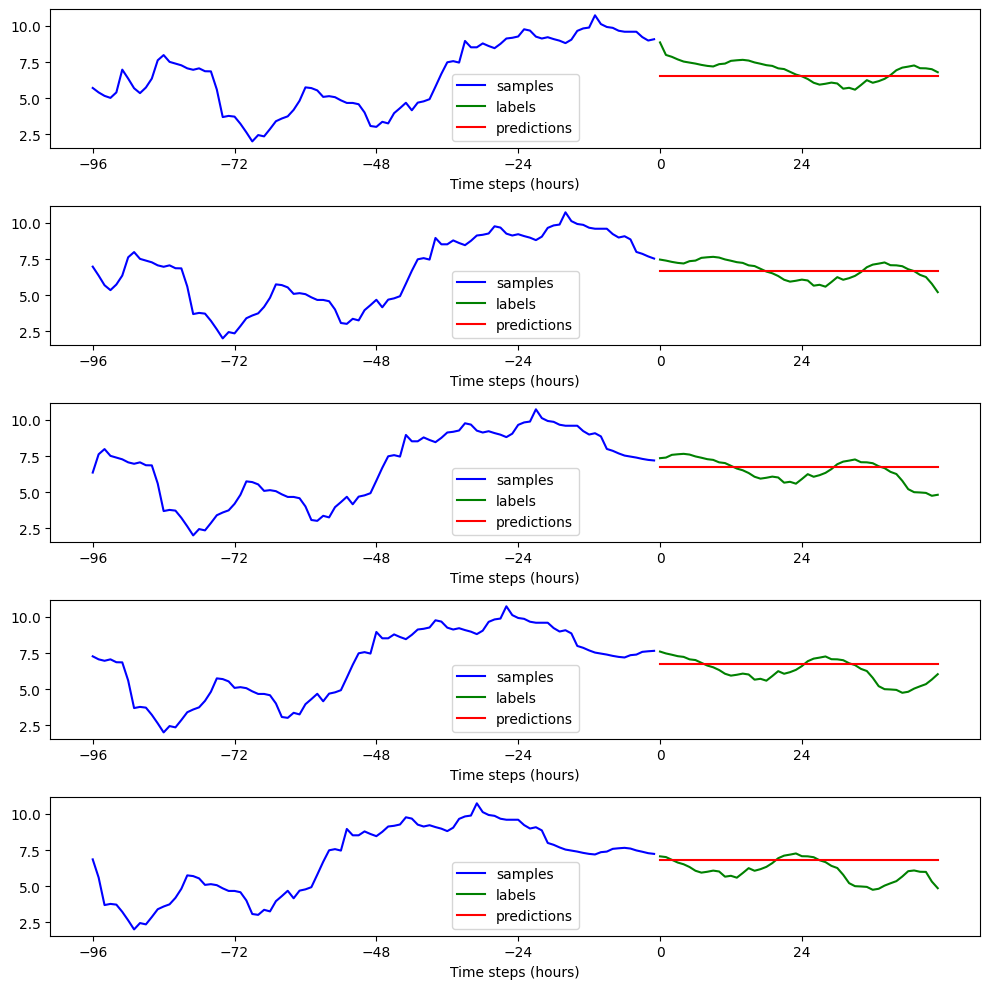

Baseline repeat_baseline


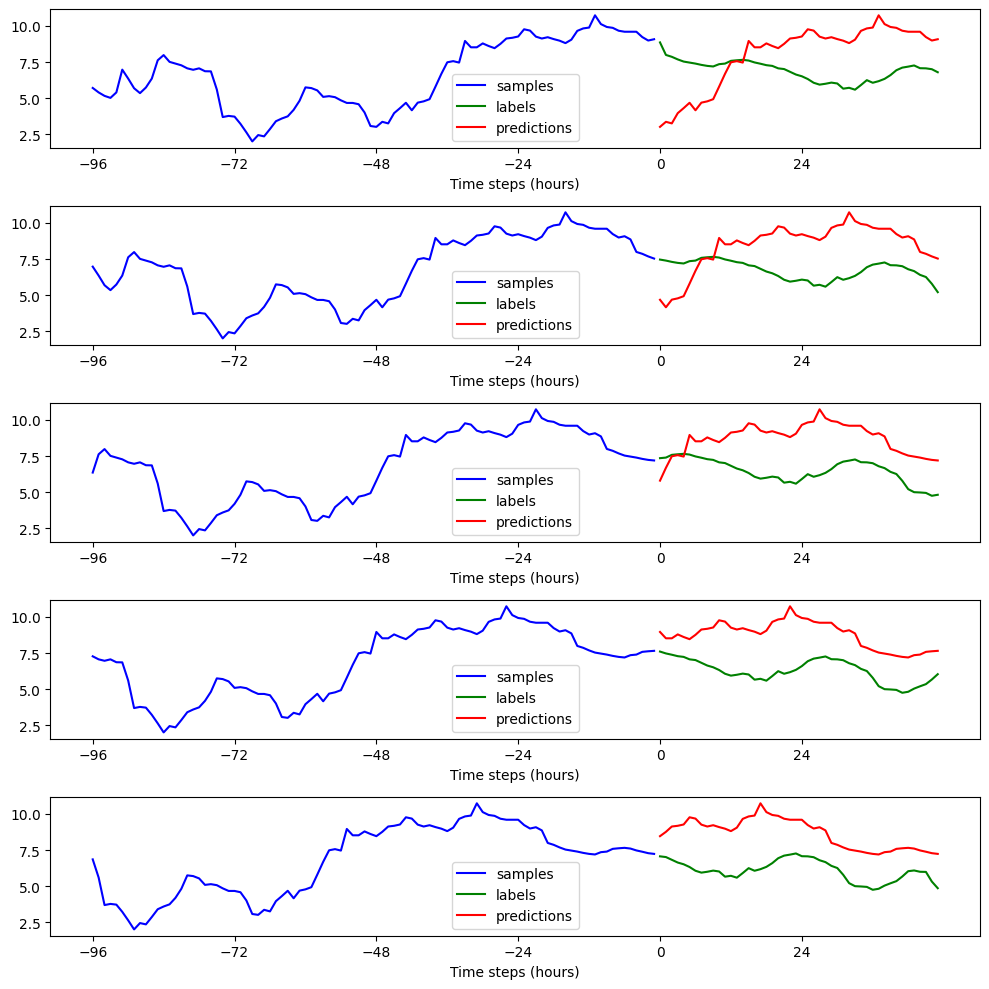

In [26]:
nb_samples_to_plot = 5

val_samples = rescale_temperatures(val_sample_windows[:, :, target_feature_id])
val_labels = rescale_temperatures(val_label_windows)

for baseline in [last_step_baseline, mean_baseline, repeat_baseline]:
    predictions = baseline(val_sample_windows)
    print(f"Baseline {baseline.__name__}")

    predictions = rescale_temperatures(predictions)

    plot_window(val_samples, val_labels, predictions, nb_samples_to_plot)

<div class="alert alert-info">

The three baseline visualization correspond to what we were trying to do.
    
This plot also shows why the reapeat baseline may be better than the two others.

### IV.3 🤖 Machine learning

The machine learning model we choose is the linear regression, we could try more complex models. However, for regressions, the linear regression is always good to try, and a more complex model will be explored in the Deep learning part.

It has the advantage of not having hyperparameters to tune, and trains quickly. Hence we choose to stay with only one model for simplicity.

Linear regression MAE: 146950059.246


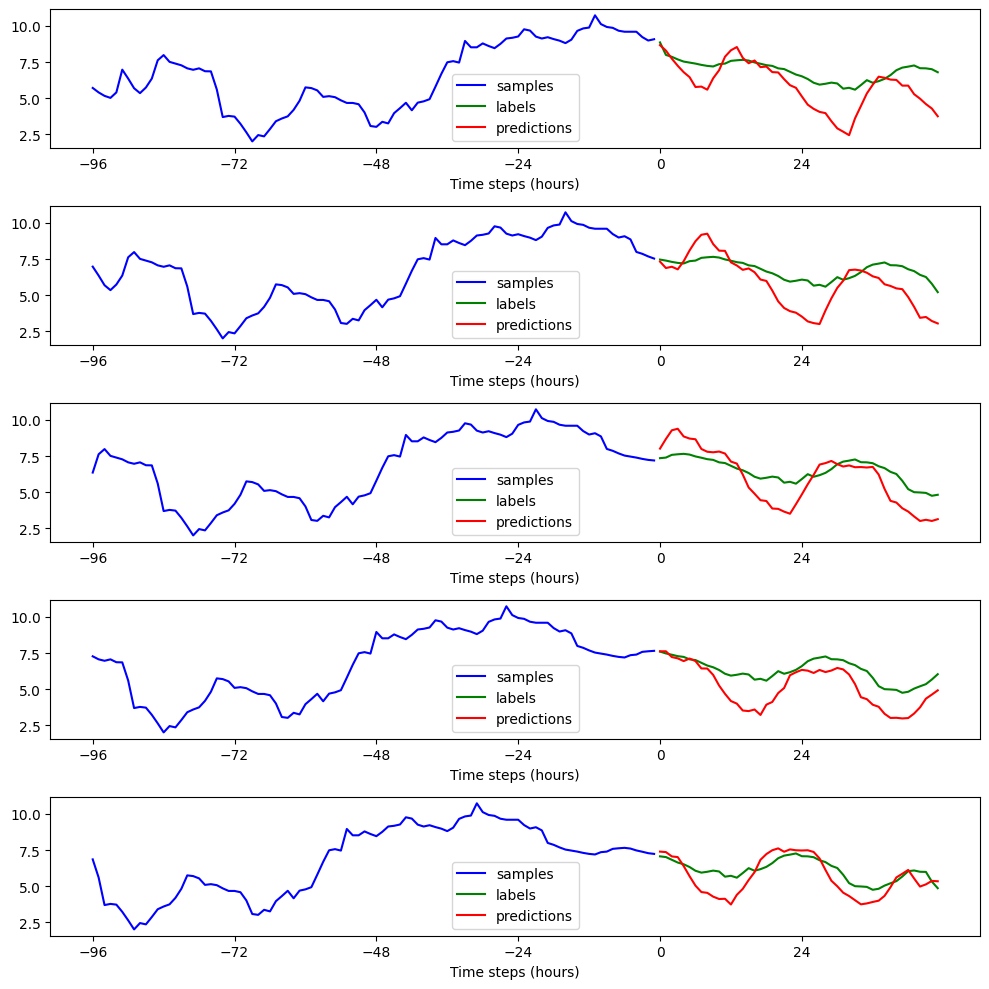

In [28]:
from sklearn.linear_model import LinearRegression

# train the linear regression
linear_model = LinearRegression()

train_samples_flattened = train_sample_windows.reshape((train_sample_windows.shape[0], -1))
val_samples_flattened = val_sample_windows.reshape((val_sample_windows.shape[0], -1))

linear_model.fit(train_samples_flattened, train_label_windows)

# evaluate the linear regression
mae = evaluate_model(linear_model.predict,
                     val_samples_flattened,
                     val_label_windows)
print(f"Linear regression MAE: {mae:.3f}")

# plot the linear regression predictions
predictions = linear_model.predict(val_samples_flattened)
predictions = rescale_temperatures(predictions)
plot_window(val_samples, val_labels, predictions, nb_samples_to_plot)

<div class="alert alert-info">

The MAE value is really high while the plot shows quite pertinent predictions, at least compared to baselines. Therefore we expect a better MAE.
    
This could be explained if the linear model predicts extreme values for some samples. I would argue that it is because of unseen data out of the initial distribution. Therefore, we will do some post-processing and clip values between the maximum and the minimum temperatures for evaluation.
    
I choose to do it for evaluation because other models may suffer from this problem and it make sense to apply the same post-processing for all models.

In [30]:
def clip(values, min_value=train_min.iloc[target_feature_id], max_value=train_max.iloc[target_feature_id]):
    values[values < min_value] = min_value
    values[values > max_value] = max_value
    return values

def evaluate_model(model, samples, labels):
    """
    Evaluate the model on the given samples and labels.
    The samples and labels are scaled back to the original scale before the mean absolute error.
    
    A clipping is applied on the rescaled predictions.
    """
    predictions = model(samples)
    predictions = clip(rescale_temperatures(predictions))
    labels = rescale_temperatures(labels)

    mae = mean_absolute_error(labels, predictions)

    return mae

Linear regression MAE: 2.934


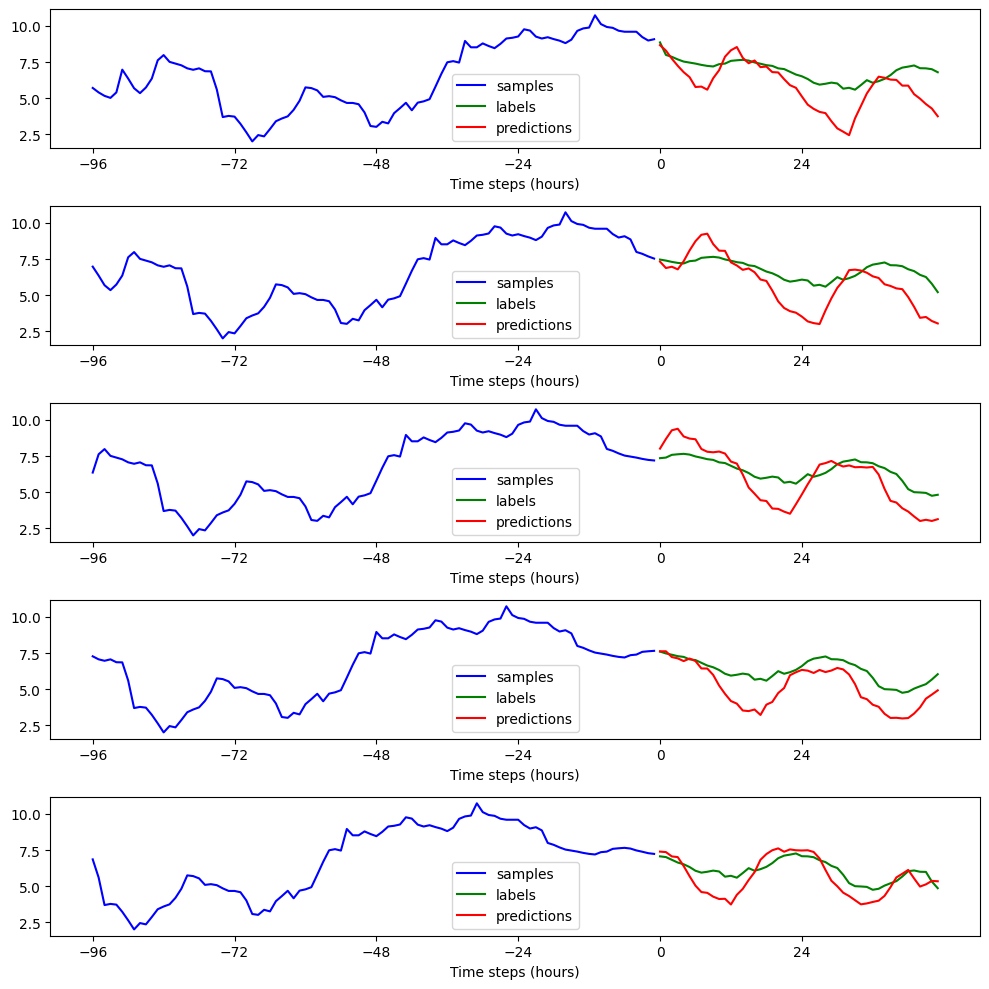

In [32]:
# evaluate the linear regression
mae = evaluate_model(linear_model.predict,
                     val_samples_flattened,
                     val_label_windows)
print(f"Linear regression MAE: {mae:.3f}")

# plot the linear regression predictions
predictions = linear_model.predict(val_samples_flattened)
predictions = rescale_temperatures(predictions)
plot_window(val_samples, val_labels, predictions, nb_samples_to_plot)

<div class="alert alert-info">

Now the mean absolute error is much more coherent with the visualization.

### IV.4 🧠 Deep learning

The model we choose is based on LSTM neurons. This model have proven his efficiency on time series over the years, hence it is natural to try it. Compared to RNN, it is better with long time series, but is still simple compare to Bi-GRU or things like that.

In [33]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#### a - Make dataloader

In [34]:
# create datasets
torch_train_dataset = TensorDataset(torch.FloatTensor(train_sample_windows),
                                    torch.FloatTensor(train_label_windows))
torch_val_dataset = TensorDataset(torch.FloatTensor(val_sample_windows),
                                  torch.FloatTensor(val_label_windows))
torch_test_dataset = TensorDataset(torch.FloatTensor(test_sample_windows),
                                   torch.FloatTensor(test_label_windows))

batch_size = 1024

# create dataloaders
train_loader = DataLoader(torch_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(torch_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(torch_test_dataset, batch_size=batch_size, shuffle=False)

#### b - Define LSTM model

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # fully connected layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out

In [37]:
# instanciate model
lstm_model = LSTMModel(input_size=train_sample_windows.shape[-1],
                       hidden_size=labels_window_size,  # arbitrary
                       num_layers=1,
                       output_size=labels_window_size)

#### c - Model training

In [38]:
# loss
criterion = nn.MSELoss()

# optimizer
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# set number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    lstm_model.train()  # Set model to training mode
    train_loss = 0.0
    for inputs, labels in train_loader:
        # forward pass
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)

    # evaluation on the validation set
    lstm_model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_loader:
            outputs = lstm_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}],\
            Train Loss: {train_loss:.4f},\
            Validation Loss: {val_loss:.4f}')

Epoch [1/10],            Train Loss: 0.9791,            Validation Loss: 0.8160
Epoch [2/10],            Train Loss: 0.9169,            Validation Loss: 0.7474
Epoch [3/10],            Train Loss: 0.8105,            Validation Loss: 0.6245
Epoch [4/10],            Train Loss: 0.6343,            Validation Loss: 0.4617
Epoch [5/10],            Train Loss: 0.4695,            Validation Loss: 0.3662
Epoch [6/10],            Train Loss: 0.3643,            Validation Loss: 0.2696
Epoch [7/10],            Train Loss: 0.3116,            Validation Loss: 0.2368
Epoch [8/10],            Train Loss: 0.2690,            Validation Loss: 0.2216
Epoch [9/10],            Train Loss: 0.2425,            Validation Loss: 0.2020
Epoch [10/10],            Train Loss: 0.2237,            Validation Loss: 0.1879


<div class="alert alert-info">

We limit our training to 10 epochs because afterwrd it overfits and the validation loss does not go down.

#### d - Evaluation

The evaluation of the LSTM on the validation dataset will decide which of the LSTM and the linear regression is the best model for our use case.

Then we will validate this performance on the test set.

In [39]:
torch_val_samples = torch.FloatTensor(val_sample_windows).detach()

lstm_model.eval()

predictions = lstm_model(torch_val_samples).detach().numpy()
predictions = rescale_temperatures(predictions)
labels = rescale_temperatures(val_label_windows)

mae = mean_absolute_error(labels, predictions)

print(f"LSTM MAE: {mae:.3f}")

# plot the lstm model predictions
plot_window(val_samples, val_labels, predictions, nb_samples_to_plot, random_samples=True)

LSTM MAE: 2.935


TypeError: plot_window() got an unexpected keyword argument 'random_samples'

<div class="alert alert-info">

The LSTM is our best model so far. At least with regards to the quantitative metric, the mean absolute error. The conclusion is not that clear with the qualitative analysis.

To be sure our model will perform well and that we did not overfit our validation dataset, we now evaluate the LSTM on the test set. 

LSTM MAE: 3.148


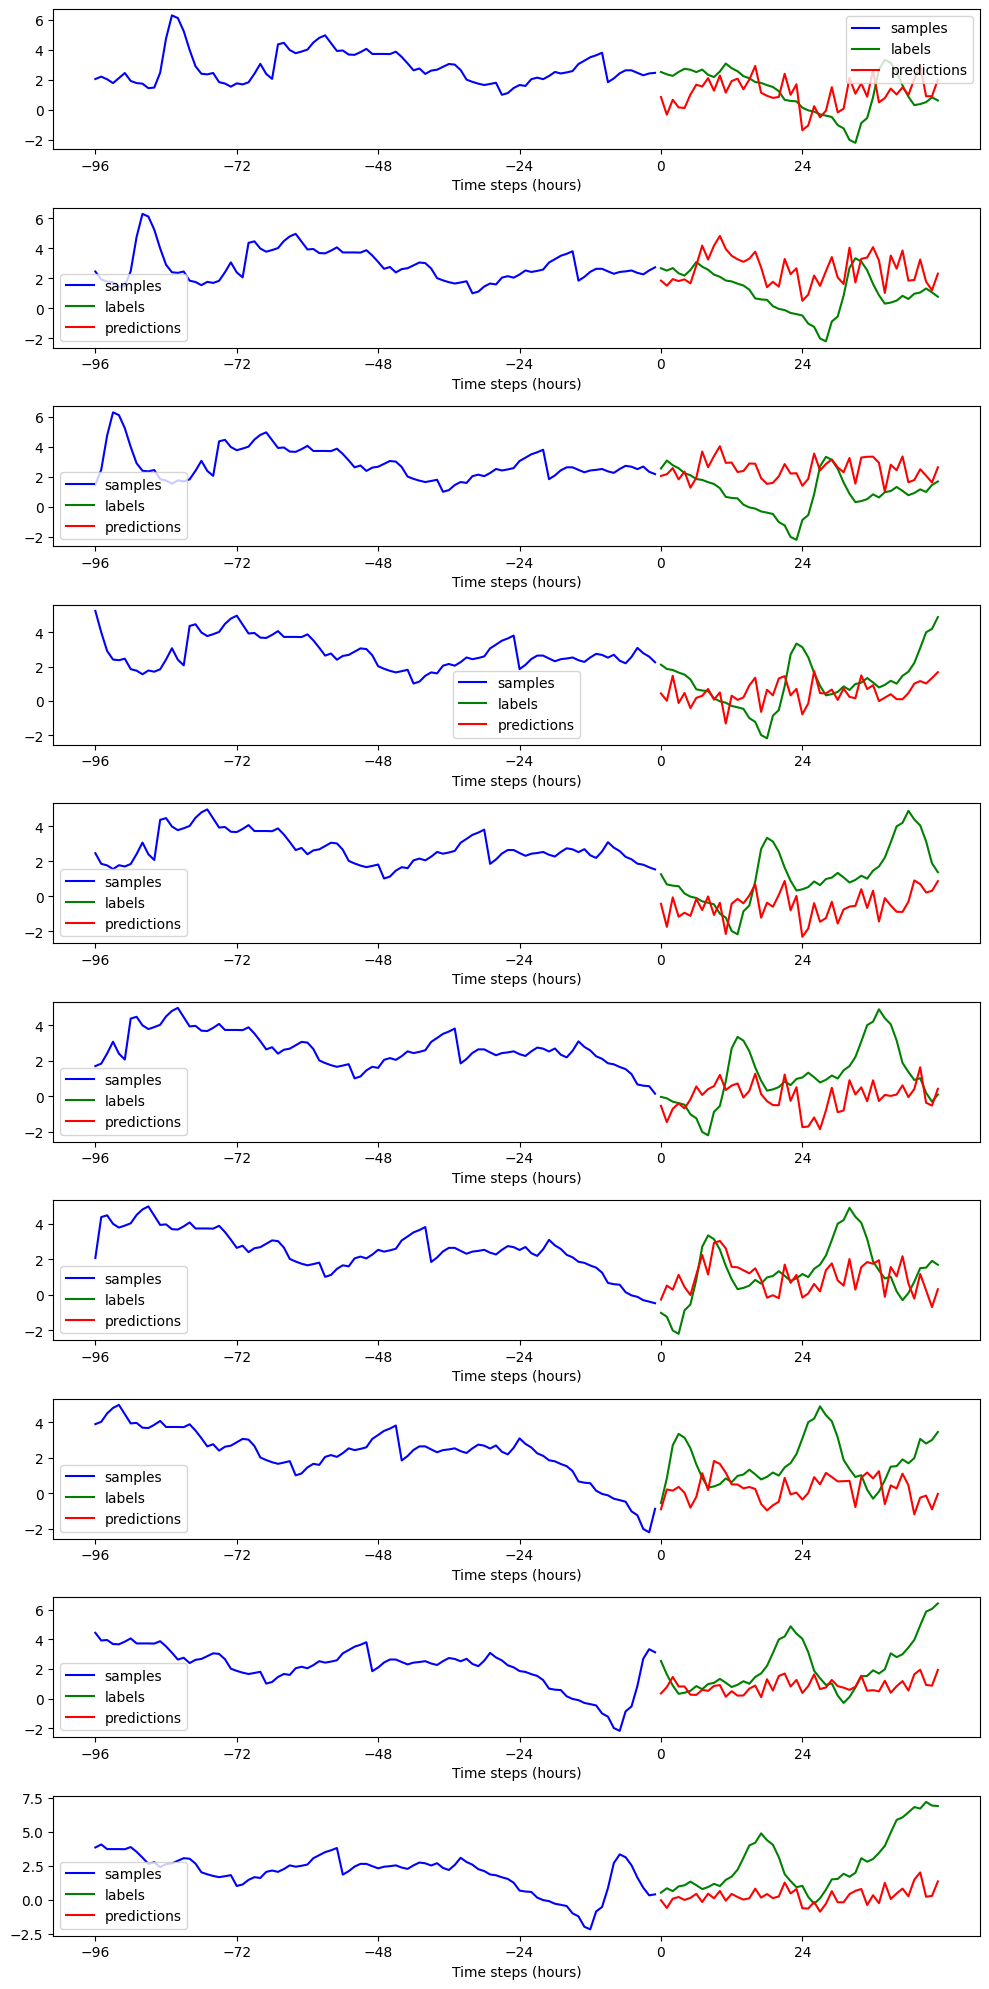

In [40]:
torch_test_samples = torch.FloatTensor(test_sample_windows)

lstm_model.eval()

predictions = lstm_model(torch_test_samples).detach().numpy()
predictions = rescale_temperatures(predictions)
labels = rescale_temperatures(test_label_windows)

mae = mean_absolute_error(labels, predictions)

print(f"LSTM MAE: {mae:.3f}")

test_samples = rescale_temperatures(test_sample_windows[:, :, target_feature_id])
test_labels = rescale_temperatures(test_label_windows)

# plot the lstm model predictions
plot_window(test_samples, test_labels, predictions, 10)

<div class="alert alert-info">

The test mean absolute error of the LSTM model is a bit worse than the validation one. However, it is still close and we can be confident that this model is the best we tried.
    
Nonetheless, it is weird how for some examples, the model make big mistakes just one hour in the future.

## Conclusions

To summarize, the task was the predictions of the temperatures for the next 48 hours with weather data. The constraint was that the model only had access to few days of previous data.

Therefore, we:
- selected a subset of pertinent variables
- explored the dataset seasonalities and trends
- divide the dataset and apply windowing
- design baselines
- train and evaluate a linear regression
- train and evaluate an lstm model

The LSTM model has proven is superiority compared to the other on this usecase. But I would still not use this model. Indeed, it is not that much better compared to knowing that the future temperature is highly correlated to the current temperature and that temperatures go up and down during the day.

Finally, we could try several thing to obtain better predictions:
- Naturally try other models and try to optimize the current LSTM hyperparameters
- Explore preprocessings, see if normalization or features selection had any positive impact.
- Try autoregressive model, were the temperature for the next hour is predicted and we use it to make the next next hour prediction and so on.